In [1]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import logging
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from sqlalchemy import create_engine

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


In [3]:
warnings.filterwarnings("ignore")
log = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s  %(levelname)-8s  %(message)s",
    handlers=[logging.FileHandler("pipeline.log"), logging.StreamHandler()],
)

DB_PATH = "quant.db"
TRADING_DAYS_PER_YEAR = 252
FIGURE_OUTPUT = "vol_analysis.png"
SURFACE_OUTPUT = "iv_surface.png"

In [4]:
# Data loading
def load_prices(engine) -> pd.DataFrame:
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql(
            "SELECT date, close, adj_close, volume FROM price_history ORDER BY date ASC",
            conn,
        )
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    price_col = "adj_close" if df["adj_close"].notna().sum() > 10 else "close"
    df["price"] = df[price_col]
    df["log_return"] = np.log(df["price"] / df["price"].shift(1))
    return df.dropna(subset=["log_return"])

def load_options(engine) -> pd.DataFrame:
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql("SELECT * FROM options_chain", conn)
    df["expiration"] = pd.to_datetime(df["expiration"])
    return df

In [5]:
# Rolling Realized Volatility
def rolling_realized_vol(df: pd.DataFrame, windows=(10, 21, 63)):
    """
    Annualized rolling realized volatility from log returns.
    windows: trading-day windows (10d ≈ 2w, 21d ≈ 1m, 63d ≈ 3m)
    """
    result = df[["log_return"]].copy()
    for w in windows:
        col = f"rvol_{w}d"
        result[col] = (
            df["log_return"].rolling(w).std() * np.sqrt(TRADING_DAYS_PER_YEAR)
        )

    log.info("[RVOL] Rolling realized volatility computed:")
    latest = result.iloc[-1]
    for w in windows:
        col = f"rvol_{w}d"
        log.info(f"  {w:>3}d RVol = {latest[col]:.2%}")

    return result

In [6]:
# GARCH(1,1) Model 
def fit_garch(df: pd.DataFrame):
    """
    Fits a GARCH(1,1) model to daily log returns.
    Returns the fitted model result and conditional volatility series.
    """
    try:
        from arch import arch_model
    except ImportError:
        log.error("arch package not installed. Run: pip install arch")
        return None, None

    returns_pct = df["log_return"] * 100  # arch expects percentage returns

    model = arch_model(
        returns_pct.dropna(),
        vol="Garch",
        p=1,
        q=1,
        mean="Constant",
        dist="normal",
    )
    result = model.fit(disp="off")

    # Conditional vol (annualized)
    cond_vol = result.conditional_volatility / 100 * np.sqrt(TRADING_DAYS_PER_YEAR)
    cond_vol.index = df.dropna(subset=["log_return"]).index[len(df.dropna()) - len(cond_vol):]

    params = result.params
    alpha = params.get("alpha[1]", np.nan)
    beta = params.get("beta[1]", np.nan)
    omega = params.get("omega", np.nan)
    persistence = alpha + beta

    log.info("[GARCH] GARCH(1,1) model fitted:")
    log.info(f"  omega={omega:.6f}, alpha={alpha:.4f}, beta={beta:.4f}")
    log.info(f"  Persistence (alpha+beta) = {persistence:.4f}")
    log.info(f"  Long-run vol = {np.sqrt(omega / (1 - persistence)) / 100 * np.sqrt(TRADING_DAYS_PER_YEAR):.2%}")
    log.info(f"  Current conditional vol  = {cond_vol.iloc[-1]:.2%}")

    return result, cond_vol

In [7]:
# Mean-Reversion (ADF Test)
def mean_reversion_analysis(df: pd.DataFrame):
    """
    Tests mean-reversion using a manual ADF-style OLS approach (no statsmodels).
    Also computes Ornstein-Uhlenbeck half-life on log returns.
    """
    from scipy import stats

    log_price = np.log(df["price"].dropna())
    ret = df["log_return"].dropna()

    # ── Manual ADF on log price (lag-1 OLS) ──────────────────────────
    y = log_price.diff().dropna()
    x = log_price.shift(1).dropna()
    x, y = x.align(y, join="inner")
    slope, intercept, r, p_level, se = stats.linregress(x, y)

    # ── Manual ADF on returns ─────────────────────────────────────────
    y2 = ret.diff().dropna()
    x2 = ret.shift(1).dropna()
    x2, y2 = x2.align(y2, join="inner")
    slope2, intercept2, r2, p_returns, se2 = stats.linregress(x2, y2)

    log.info("[MEAN-REV] ADF-style regression results:")
    log.info(
        f"  Log price  — slope: {slope:.4f}, p-value: {p_level:.4f} "
        f"({'NON-stationary ✓' if p_level > 0.05 else 'Stationary'})"
    )
    log.info(
        f"  Log returns — slope: {slope2:.4f}, p-value: {p_returns:.4f} "
        f"({'Stationary ✓' if p_returns < 0.05 else 'NON-stationary'})"
    )

    # ── OU half-life ──────────────────────────────────────────────────
    lagged = ret.shift(1).dropna()
    current = ret.iloc[1:]
    ou_slope = np.polyfit(lagged, current, 1)[0]
    half_life = -np.log(2) / np.log(abs(ou_slope)) if ou_slope < 0 else np.inf
    log.info(f"  OU half-life (log returns): {half_life:.1f} trading days")

    return {
        "adf_level_slope": slope,
        "adf_level_pval": p_level,
        "adf_returns_slope": slope2,
        "adf_returns_pval": p_returns,
        "ou_half_life_days": half_life,
    }

In [8]:
# Implied Volatility Surface 
def implied_vol_surface(options_df: pd.DataFrame):
    """
    Computes and returns a pivot table (moneyness × expiration) of IV.
    Moneyness = strike / current_spot (approximated from ATM strike).
    """
    if options_df.empty:
        log.warning("[IV SURFACE] No options data available.")
        return pd.DataFrame()

    df = options_df.copy()

    # Use calls only for the surface
    calls = df[df["option_type"] == "call"].copy()
    calls = calls[calls["implied_vol"] > 0.01]   # remove zero/garbage IV
    calls = calls[calls["implied_vol"] < 5.0]    # remove extreme IV

    if calls.empty:
        log.warning("[IV SURFACE] No valid call IV data.")
        return pd.DataFrame()

    # Approximate spot: ATM strike is roughly where IV is lowest per expiry
    def atm_strike(group):
        return group.loc[group["implied_vol"].idxmin(), "strike"]

    atm = calls.groupby("expiration").apply(atm_strike).rename("atm_strike")
    calls = calls.merge(atm, on="expiration")
    calls["moneyness"] = calls["strike"] / calls["atm_strike"]

    # Bin moneyness for cleaner surface (0.80 to 1.20, 5% buckets)
    bins = np.arange(0.80, 1.25, 0.05)
    labels = [f"{b:.2f}" for b in bins[:-1]]
    calls["moneyness_bin"] = pd.cut(
        calls["moneyness"], bins=bins, labels=labels, include_lowest=True
    )

    # Days to expiration
    today = pd.Timestamp.today().normalize()
    calls["dte"] = (calls["expiration"] - today).dt.days

    # Pivot: rows = moneyness, cols = DTE, values = mean IV
    surface = calls.pivot_table(
        index="moneyness_bin",
        columns="dte",
        values="implied_vol",
        aggfunc="mean",
    )
    surface = surface.dropna(how="all", axis=0).dropna(how="all", axis=1)

    log.info(f"[IV SURFACE] Surface shape: {surface.shape} (moneyness bins × expirations)")
    return surface

In [9]:
# Vol Risk Premium 
def vol_risk_premium(price_df: pd.DataFrame, options_df: pd.DataFrame):
    """
    VRP = implied vol - realized vol (same horizon).
    Positive VRP = options overpriced vs realised vol → sellers earn premium.
    """
    if options_df.empty:
        log.warning("[VRP] No options data for VRP calc.")
        return

    # 21-day realized vol (annualized)
    rvol_21 = (
        price_df["log_return"].rolling(21).std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    ).iloc[-1]

    # Mean ATM IV across nearest expiration
    near_exp = options_df["expiration"].min()
    atm_iv = options_df[
        (options_df["expiration"] == near_exp) &
        (options_df["implied_vol"] > 0.01) &
        (options_df["implied_vol"] < 5.0)
    ]["implied_vol"].mean()

    vrp = atm_iv - rvol_21
    log.info("[VRP] Volatility Risk Premium:")
    log.info(f"  21d Realized Vol  = {rvol_21:.2%}")
    log.info(f"  Near-term ATM IV  = {atm_iv:.2%}")
    log.info(f"  VRP (IV - RVol)   = {vrp:+.2%}  ({'rich' if vrp > 0 else 'cheap'} options)")
    return {"rvol_21d": rvol_21, "atm_iv": atm_iv, "vrp": vrp}

In [10]:
# Plotting 
def plot_vol_analysis(price_df, rvol_df, garch_vol):
    sns.set_theme(style="darkgrid", palette="muted")
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)
    fig.suptitle("SPY Volatility Analysis", fontsize=14, fontweight="bold")

    # Panel 1: Price history
    ax1 = axes[0]
    ax1.plot(price_df.index, price_df["price"], color="#2196F3", linewidth=1.2)
    ax1.set_title("Price History (Adjusted Close)")
    ax1.set_ylabel("Price ($)")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    # Panel 2: Rolling Realized Vol
    ax2 = axes[1]
    colors = {"rvol_10d": "#FF5722", "rvol_21d": "#4CAF50", "rvol_63d": "#9C27B0"}
    labels = {"rvol_10d": "10d RVol", "rvol_21d": "21d RVol", "rvol_63d": "63d RVol"}
    for col, color in colors.items():
        if col in rvol_df.columns:
            ax2.plot(rvol_df.index, rvol_df[col] * 100, label=labels[col], color=color, linewidth=1.0)
    ax2.set_title("Rolling Realized Volatility (Annualized %)")
    ax2.set_ylabel("Volatility (%)")
    ax2.legend(loc="upper right", fontsize=8)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    # Panel 3: GARCH conditional vol
    ax3 = axes[2]
    if garch_vol is not None and len(garch_vol) > 0:
        ax3.plot(garch_vol.index, garch_vol * 100, color="#FF9800", linewidth=1.0, label="GARCH(1,1)")
        ax3.set_title("GARCH(1,1) Conditional Volatility (Annualized %)")
        ax3.set_ylabel("Volatility (%)")
        ax3.legend(loc="upper right", fontsize=8)
        ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    else:
        ax3.text(0.5, 0.5, "GARCH not computed (install arch)", ha="center", va="center", transform=ax3.transAxes)

    plt.tight_layout()
    plt.savefig(FIGURE_OUTPUT, dpi=150, bbox_inches="tight")
    log.info(f"Saved: {FIGURE_OUTPUT}")
    plt.close()


def plot_iv_surface(surface: pd.DataFrame):
    if surface.empty:
        log.warning("Skipping IV surface plot — no data.")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(
        surface.astype(float),
        ax=ax,
        cmap="RdYlGn_r",
        annot=True,
        fmt=".0%",
        linewidths=0.5,
        cbar_kws={"label": "Implied Volatility"},
    )
    ax.set_title("Implied Volatility Surface — Calls (Moneyness × Days to Expiry)", fontsize=12)
    ax.set_xlabel("Days to Expiration")
    ax.set_ylabel("Moneyness (Strike / ATM)")
    plt.tight_layout()
    plt.savefig(SURFACE_OUTPUT, dpi=150, bbox_inches="tight")
    log.info(f"Saved: {SURFACE_OUTPUT}")
    plt.close()

2026-02-17 23:16:49,791  INFO      ============================================================
2026-02-17 23:16:49,793  INFO      ANALYSIS PIPELINE START
2026-02-17 23:16:49,794  INFO      ============================================================
2026-02-17 23:16:49,825  INFO      [RVOL] Rolling realized volatility computed:
2026-02-17 23:16:49,826  INFO         10d RVol = 15.49%
2026-02-17 23:16:49,826  INFO         21d RVol = 13.94%
2026-02-17 23:16:49,826  INFO         63d RVol = 11.47%
2026-02-17 23:16:49,845  INFO      [GARCH] GARCH(1,1) model fitted:
2026-02-17 23:16:49,846  INFO        omega=0.059665, alpha=0.1208, beta=0.8119
2026-02-17 23:16:49,846  INFO        Persistence (alpha+beta) = 0.9326
2026-02-17 23:16:49,846  INFO        Long-run vol = 14.94%
2026-02-17 23:16:49,847  INFO        Current conditional vol  = 14.71%
2026-02-17 23:16:49,849  INFO      [MEAN-REV] ADF-style regression results:
2026-02-17 23:16:49,850  INFO        Log price  — slope: -0.0061, p-value: 0.

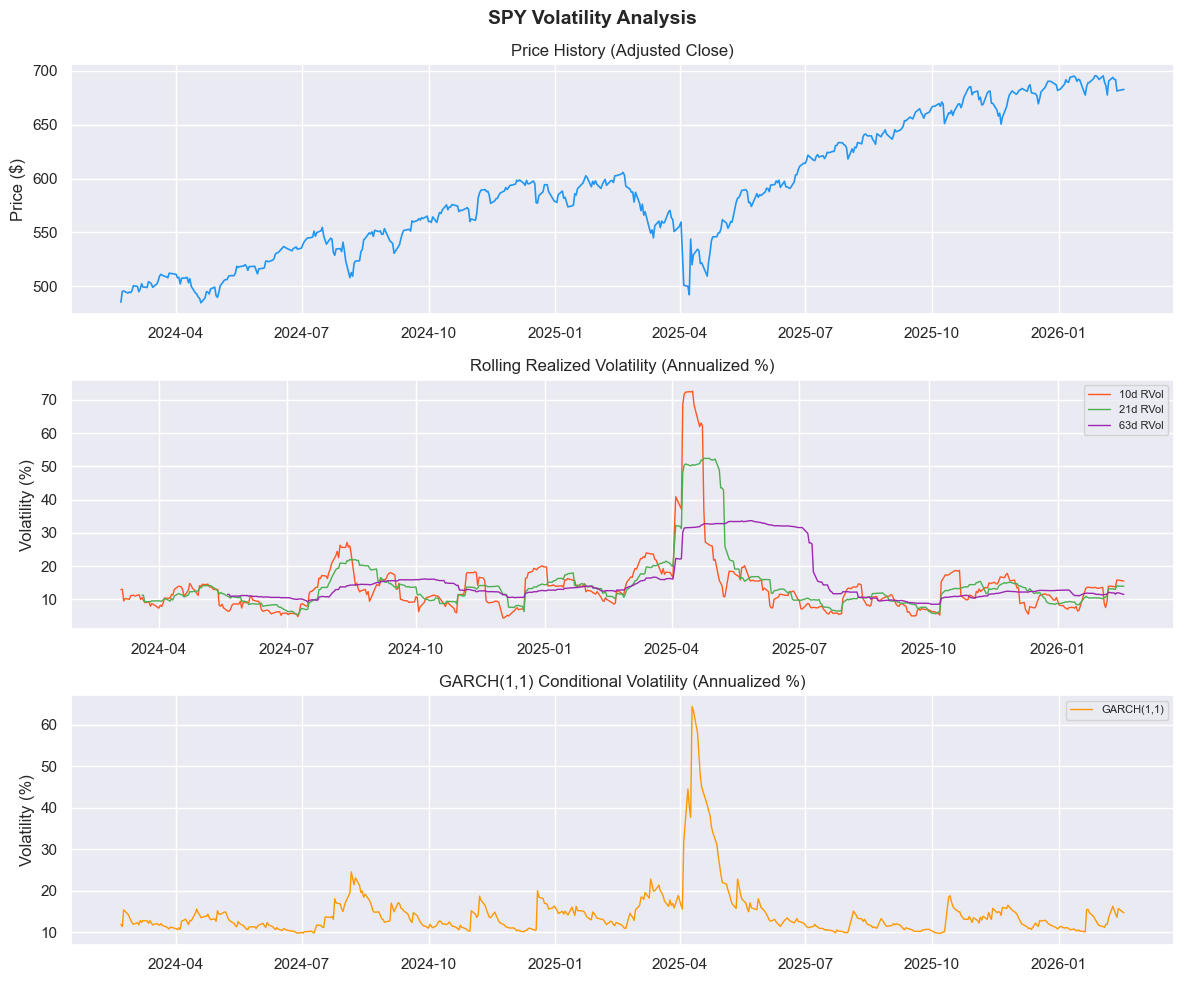

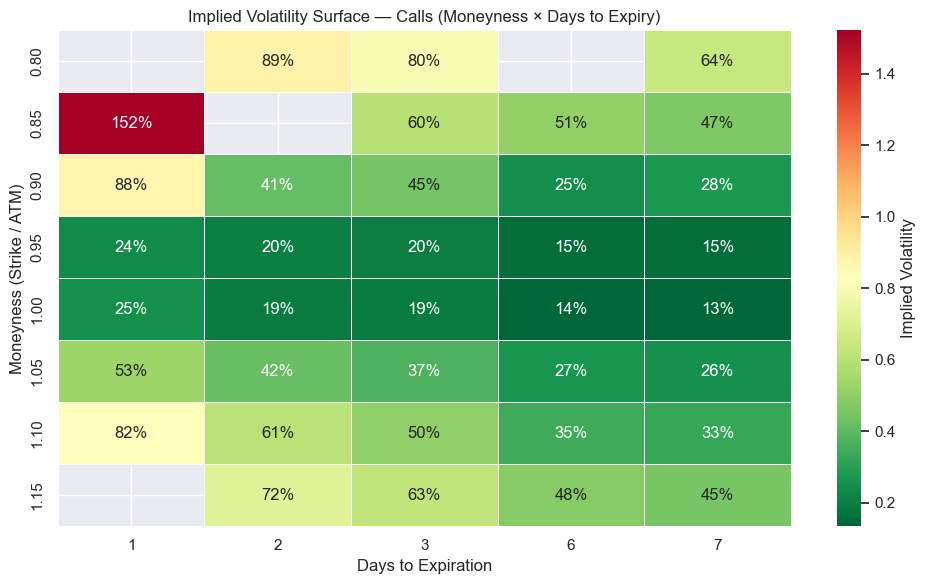

2026-02-17 23:16:50,644  INFO      ============================================================
2026-02-17 23:16:50,644  INFO      ANALYSIS COMPLETE
2026-02-17 23:16:50,645  INFO      ============================================================


In [32]:
# Main 
def run_analysis(engine=None):
    if engine is None:
        engine = create_engine(f"sqlite:///{DB_PATH}", echo=False)

    log.info("=" * 60)
    log.info("ANALYSIS PIPELINE START")
    log.info("=" * 60)

    price_df = load_prices(engine)
    options_df = load_options(engine)

    if price_df.empty:
        log.error("No price data in DB. Run etl.py first.")
        return

    # 1. Rolling vol
    rvol_df = rolling_realized_vol(price_df)

    # 2. GARCH
    garch_result, garch_vol = fit_garch(price_df)

    # 3. Mean reversion
    mr_stats = mean_reversion_analysis(price_df)

    # 4. IV surface
    surface = implied_vol_surface(options_df)

    # 5. VRP
    if not options_df.empty:
        vrp = vol_risk_premium(price_df, options_df)

    # Plots
    plot_vol_analysis(price_df, rvol_df, garch_vol)
    plot_iv_surface(surface)

    log.info("=" * 60)
    log.info("ANALYSIS COMPLETE")
    log.info("=" * 60)

    return {
        "price_df": price_df,
        "rvol_df": rvol_df,
        "garch_result": garch_result,
        "garch_vol": garch_vol,
        "mr_stats": mr_stats,
        "iv_surface": surface,
    }


if __name__ == "__main__":
    run_analysis()

In [26]:
def plot_vol_analysis(price_df, rvol_df, garch_vol):
    sns.set_theme(style="darkgrid", palette="muted")
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)
    fig.suptitle("SPY Volatility Analysis", fontsize=14, fontweight="bold")

    ax1 = axes[0]
    ax1.plot(price_df.index, price_df["price"], color="#2196F3", linewidth=1.2)
    ax1.set_title("Price History (Adjusted Close)")
    ax1.set_ylabel("Price ($)")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    ax2 = axes[1]
    colors = {"rvol_10d": "#FF5722", "rvol_21d": "#4CAF50", "rvol_63d": "#9C27B0"}
    labels = {"rvol_10d": "10d RVol", "rvol_21d": "21d RVol", "rvol_63d": "63d RVol"}
    for col, color in colors.items():
        if col in rvol_df.columns:
            ax2.plot(rvol_df.index, rvol_df[col] * 100, label=labels[col], color=color, linewidth=1.0)
    ax2.set_title("Rolling Realized Volatility (Annualized %)")
    ax2.set_ylabel("Volatility (%)")
    ax2.legend(loc="upper right", fontsize=8)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    ax3 = axes[2]
    if garch_vol is not None and len(garch_vol) > 0:
        ax3.plot(garch_vol.index, garch_vol * 100, color="#FF9800", linewidth=1.0, label="GARCH(1,1)")
        ax3.set_title("GARCH(1,1) Conditional Volatility (Annualized %)")
        ax3.set_ylabel("Volatility (%)")
        ax3.legend(loc="upper right", fontsize=8)
        ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    else:
        ax3.text(0.5, 0.5, "GARCH not computed (install arch)", ha="center", va="center", transform=ax3.transAxes)

    plt.tight_layout()
    plt.show() 


def plot_iv_surface(surface: pd.DataFrame):
    if surface.empty:
        log.warning("Skipping IV surface plot — no data.")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(
        surface.astype(float),
        ax=ax,
        cmap="RdYlGn_r",
        annot=True,
        fmt=".0%",
        linewidths=0.5,
        cbar_kws={"label": "Implied Volatility"},
    )
    ax.set_title("Implied Volatility Surface — Calls (Moneyness × Days to Expiry)", fontsize=12)
    ax.set_xlabel("Days to Expiration")
    ax.set_ylabel("Moneyness (Strike / ATM)")
    plt.tight_layout()
    plt.show()  

In [30]:
# Plots
plot_vol_analysis(price_df, rvol_df, garch_vol)
plot_iv_surface(surface)

NameError: name 'price_df' is not defined